LP qubit routing creation


We start with one simple change of the variables integrality. 

In [5]:
import copy

import networkx as nx
import numpy as np
from dataclasses import dataclass, field
from enum import Enum
from collections import defaultdict

import quariadne.circuit
import scipy.optimize
import scipy.sparse
import qiskit.transpiler


DEFAULT_SHAPE_TYPE = np.uint32
DEFAULT_CONSTRAINT_TYPE = np.float64

# Optimisation coefficient constants
QUBIT_MOVEMENT_PENALTY_COEFFICIENT = 0.5

# Constraint name constants
LOGICAL_UNIQUENESS_CONSTRAINT = "logical_uniqueness_constraint"
PHYSICAL_UNIQUENESS_CONSTRAINT = "physical_uniqueness_constraint"
GATE_EXECUTION_CONSTRAINT = "gate_execution_constraint"
GATE_MAPPING_CONSTRAINT = "gate_mapping_constraint"
GATE_MAPPING_LEFT_QUBIT_CONSTRAINT = "gate_mapping_left_qubit_constraint"
GATE_MAPPING_RIGHT_QUBIT_CONSTRAINT = "gate_mapping_right_qubit_constraint"
GATE_MAPPING_FULL_QUBIT_CONSTRAINT = "gate_mapping_full_qubit_constraint"
FLOW_CONDITION_IN_CONSTRAINT = "flow_condition_in_constraint"
FLOW_CONDITION_OUT_CONSTRAINT = "flow_condition_out_constraint"

# Constraint bound value constants
ONE_EQUALITY_CONSTRAINT_BOUND = 1
ZERO_EQUALITY_CONSTRAINT_BOUND = 0
OPEN_LOWER_CONSTRAINT_BOUND = -np.inf
OPEN_UPPER_CONSTRAINT_BOUND = np.inf
MINUS_ONE_LOWER_BOUND = -1

# Variable bound constants
BINARY_VARIABLE_LOWER_BOUND = 0
BINARY_VARIABLE_UPPER_BOUND = 1
INTEGER_VARIABLE_INTEGRALITY = 0


class RoutingVariableType(Enum):
    """Enum for variable types in MILP optimization."""

    MAPPING = "mapping"
    GATE_EXECUTION = "gate_execution"
    QUBIT_MOVEMENT = "qubit_movement"


# Variable registry field constants
VARIABLE_SHAPE = "shape"
VARIABLE_FLAT_SHAPE = "flat_shape"
VARIABLE_OFFSET = "offset"


@dataclass
class ConstraintMatrixSparseData:
    """Container for sparse constraint matrix data during MILP constraint generation.

    Holds the coefficient data, row indices, and column indices needed to construct
    sparse constraint coefficient matrices efficiently. Shape is inferred during creation.

    Attributes:
        data: List of non-zero coefficient values
        row_indices: List of row indices corresponding to each coefficient
        col_indices: List of column indices corresponding to each coefficient
    """

    data: list[np.floating] = field(default_factory=list)
    row_indices: list[np.integer] = field(default_factory=list)
    col_indices: list[np.integer] = field(default_factory=list)

    def add_coefficient(
        self, value: float, row_index: np.integer, col_index: np.integer
    ) -> None:  # TODO: Fix typing!
        """Add a coefficient triplet to the sparse matrix data.

        Args:
            value: Coefficient value to add
            row_index: Row index for this coefficient
            col_index: Column index for this coefficient
        """
        converted_value = DEFAULT_CONSTRAINT_TYPE(value)
        self.data.append(converted_value)
        self.row_indices.append(row_index)
        self.col_indices.append(col_index)


@dataclass
class LpRouterResult:
    """Result container for MILP router optimization with processed variable matrices.

    Contains the three groups of decision variables from the MILP solution in unflattened form:
    - mapping_variables: qubit-to-physical mapping at each timestep
    - gate_execution_variables: which gates execute on which physical edges
    - qubit_movement_variables: qubit movement between physical locations
    """

    milp_result: scipy.optimize.OptimizeResult
    mapping_variables: np.ndarray
    gate_execution_variables: np.ndarray
    qubit_movement_variables: np.ndarray
    worst_spacing: int

    @property
    def initial_mapping(
        self,
    ) -> dict[quariadne.circuit.LogicalQubit, quariadne.circuit.PhysicalQubit]:
        """Calculate initial mapping from mapping variables at timestep 0.

        Extracts the mapping at the first timestep (t=0) and returns a dictionary
        mapping logical qubits to physical qubits for the initial state.

        Returns:
            Dictionary mapping LogicalQubit objects to PhysicalQubit objects
            representing the initial qubit mapping.
        """
        # Extract the mapping matrix at timestep 0
        initial_timestep_mapping = self.mapping_variables[0]

        # Find all non-zero positions (physical_idx, logical_idx) where mapping exists
        initial_mapping_indices = np.argwhere(initial_timestep_mapping)

        # Convert numpy array to Python list for iteration
        # tolist() ensures we get Python integers rather than numpy.int64 objects
        # which are required for the PhysicalQubit and LogicalQubit constructors
        initial_mapping_indices_list = initial_mapping_indices.tolist()

        # Build the mapping dictionary (logical → physical, matching notebook implementation)
        mapping_dict = {}
        for physical_idx, logical_idx in initial_mapping_indices_list:
            physical_qubit = quariadne.circuit.PhysicalQubit(physical_idx)
            logical_qubit = quariadne.circuit.LogicalQubit(logical_idx)
            mapping_dict[logical_qubit] = physical_qubit

        return mapping_dict

    @property
    def inserted_swaps(self) -> dict[int, list[frozenset[int]]]:
        """Extract swap operations from qubit movement variables.

        Analyses the qubit movement variables to identify SWAP operations that occur
        after each operation timestep. SWAP operations are detected by finding pairs of
        qubits that exchange positions between physical locations.

        Returns:
            Dictionary mapping operation indices (0-based) to lists of swap pairs.
            Each swap pair is represented as a frozenset of two physical qubit indices.

        Example:
            {
                0: [],  # No swaps after operation 0
                1: [frozenset({0, 1})],  # SWAP between physical qubits 0 and 1 after operation 1
                2: [frozenset({2, 3}), frozenset({0, 4})]  # Two SWAPs after operation 2
            }
        """
        swap_pairs_by_operation = defaultdict(list)

        # Find all non-zero movement variables where actual movement occurs
        defined_movements = np.argwhere(self.qubit_movement_variables)

        for movement in defined_movements:
            timestep, logical_qubit, from_qubit, to_qubit = movement.tolist()

            # Only consider actual movements (not self-assignments)
            if from_qubit != to_qubit:
                # Convert timestep to operation index using worst_spacing division
                # The +1 is an offset accounting for the fact that swaps happen AFTER respective operations
                operation_index = timestep // self.worst_spacing + 1

                # Create swap pair as frozenset (immutable set) to treat swaps as bidirectional
                # and enable proper duplicate detection regardless of qubit ordering
                swap_pair = frozenset((from_qubit, to_qubit))

                # Get current operation's swap list
                current_operation_swaps = swap_pairs_by_operation[operation_index]

                # Add swap pair if not already present (avoids duplicates)
                if swap_pair not in current_operation_swaps:
                    current_operation_swaps.append(swap_pair)

        return swap_pairs_by_operation


def get_coupling_graph(coupling_map: qiskit.transpiler.CouplingMap) -> nx.DiGraph:
    """Convert IBM coupling map to NetworkX DiGraph coupling map.

    Converts a Qiskit CouplingMap object to a NetworkX DiGraph using
    Quariadne's PhysicalQubit representation for nodes and edges.

    Args:
        coupling_map: Qiskit CouplingMap object representing physical qubit
                     connectivity (e.g., backend.coupling_map)

    Returns:
        NetworkX DiGraph with PhysicalQubit nodes and edges representing
        physical qubit connectivity on the hardware backend.

    Example:
        >>> from qiskit_ibm_runtime.fake_provider import FakeManilaV2
        >>> backend = FakeManilaV2()
        >>> coupling_graph = get_coupling_graph(backend.coupling_map)
        >>> print(coupling_graph.nodes())
        >>> print(coupling_graph.edges())
    """
    coupling_graph_nx = nx.DiGraph()

    # Extract physical qubits from coupling map
    coupling_map_qubits = coupling_map.physical_qubits
    physical_qubits = tuple(
        quariadne.circuit.PhysicalQubit(coupling_map_qubit)
        for coupling_map_qubit in coupling_map_qubits
    )

    # Extract edges from coupling map
    coupling_map_edgelist = coupling_map.graph.edge_list()
    physical_qubits_connections = tuple(
        (
            quariadne.circuit.PhysicalQubit(coupling_map_from),
            quariadne.circuit.PhysicalQubit(coupling_map_to),
        )
        for coupling_map_from, coupling_map_to in coupling_map_edgelist
    )

    # Build NetworkX graph
    coupling_graph_nx.add_nodes_from(physical_qubits)
    coupling_graph_nx.add_edges_from(physical_qubits_connections)

    return coupling_graph_nx


class LpRouter:
    """Mixed-Integer Linear Programming router for quantum circuit qubit routing.

    Implements a MILP-based approach to solve the quantum circuit routing problem,
    where logical qubits must be mapped to physical qubits while respecting hardware
    coupling constraints. The router uses scipy.optimize.milp to find optimal
    qubit mappings and SWAP operations.

    The MILP formulation includes three types of decision variables:
    - Mapping variables: qubit-to-physical mapping at each timestep
    - Gate execution variables: which gates execute on which physical edges
    - Qubit movement variables: qubit movement between physical locations

    Attributes:
        coupling_map: NetworkX DiGraph representing hardware connectivity
        routed_circuit: Abstract quantum circuit to be routed
        qubit_count: Number of physical qubits available
        operations: List of two-qubit operations to be routed
        operation_count: Number of operations to route
        worst_spacing: Worst-case timesteps for token swapping
        spaced_timesteps_count: Total timesteps in routing schedule
    """


    def _add_dummy_qubits(self):
        """Add dummy logical qubits to match hardware qubit count.

        Ensures the circuit has the same number of logical qubits as physical qubits
        available on the hardware. This is required for the MILP formulation to work
        correctly as it assumes a bijective mapping between logical and physical qubits.

        Raises:
            TypeError: If the circuit has more logical qubits than available physical qubits.
        """
        routed_circuit_qubit_count = len(self.routed_circuit.qubits)
        if routed_circuit_qubit_count < self.coupling_map.number_of_nodes():
            dummy_logical_qubits = tuple(
                quariadne.circuit.LogicalQubit(dummy_index)
                for dummy_index in range(routed_circuit_qubit_count, self.qubit_count)
            )
            self.routed_circuit.qubits = (
                self.routed_circuit.qubits + dummy_logical_qubits
            )

        elif routed_circuit_qubit_count > self.coupling_map.number_of_nodes():
            raise TypeError("We got more qubits than we can route!")

    def _get_two_qubit_operations(self):
        """Extract two-qubit operations from the quantum circuit.

        Filters the circuit operations to include only two-qubit gates, which are the
        ones that require routing due to coupling map constraints. Single-qubit operations
        can be executed on any physical qubit without routing considerations.

        Returns:
            List of QuantumOperation objects that involve exactly two qubits.

        Raises:
            TypeError: If any operation involves more than two qubits.
        """
        two_qubit_gate_operations = []
        for operation in self.routed_circuit.operations:
            if len(operation.qubits_participating) == 2:
                two_qubit_gate_operations.append(operation)
            elif len(operation.qubits_participating) > 2:
                raise TypeError("We got much more qubits that we want!")

        return two_qubit_gate_operations

    def __init__(
        self,
        coupling_map: nx.DiGraph,
        quantum_circuit: quariadne.circuit.AbstractQuantumCircuit,
    ):
        """Initialize the MILP router with hardware topology and quantum circuit.

        Sets up all necessary data structures for the MILP formulation including:
        - Variable shapes and offsets for mapping, gate execution, and qubit movement
        - Constraint generation registry with bounds
        - Timestep calculations based on worst-case token swapping

        Args:
            coupling_map: NetworkX DiGraph representing the physical qubit connectivity
                         and allowed two-qubit gate operations on the hardware.
            quantum_circuit: Abstract quantum circuit representation containing logical
                           qubits and operations to be routed onto the hardware.
        """
        self.coupling_map = coupling_map
        self.qubit_count = coupling_map.number_of_nodes()

        # copy is needed because we will modify the initial circuit several times.
        self.routed_circuit = copy.deepcopy(quantum_circuit)


        # calculating the parameters of the circuit
        # worst spacing is the token swapping worst case $n^2$,
        # the tokens are calculated before dummy qubits addition
        self.worst_spacing = len(self.routed_circuit.qubits)**2


        self._add_dummy_qubits()

        self.operations = self._get_two_qubit_operations()
        self.operation_count = len(self.operations)
        self.spaced_timesteps_count = self.operation_count * self.worst_spacing

        # calculating the shapes of the decision variables
        self.qubit_movement_shape = (
            self.spaced_timesteps_count,
            self.qubit_count,
            self.qubit_count,
            self.qubit_count,
        )
        self.mapping_variables_shape = (
            self.spaced_timesteps_count,
            self.qubit_count,
            self.qubit_count,
        )
        self.gate_execution_variables_shape = (
            self.spaced_timesteps_count,
            self.operation_count,
            self.coupling_map.number_of_edges(),
        )

        self.flat_qubit_movement_shape = np.prod(
            self.qubit_movement_shape, dtype=DEFAULT_SHAPE_TYPE
        )
        self.flat_mapping_variables_shape = np.prod(
            self.mapping_variables_shape, dtype=DEFAULT_SHAPE_TYPE
        )
        self.flat_gate_execution_variables_shape = np.prod(
            self.gate_execution_variables_shape, dtype=DEFAULT_SHAPE_TYPE
        )
        self.full_decision_variables_shape = (
            self.flat_mapping_variables_shape
            + self.flat_gate_execution_variables_shape
            + self.flat_qubit_movement_shape
        )

        # Precalculated variable offsets
        self.mapping_variables_offset = 0
        self.gate_execution_variables_offset = self.flat_mapping_variables_shape
        self.qubit_movement_variables_offset = (
            self.flat_mapping_variables_shape + self.flat_gate_execution_variables_shape
        )

        self.coupling_map_edges = list(self.coupling_map.edges())

        # Variable type registry with shapes, flat shapes, and offsets
        self.variable_types = {
            RoutingVariableType.MAPPING: {
                VARIABLE_SHAPE: self.mapping_variables_shape,
                VARIABLE_FLAT_SHAPE: self.flat_mapping_variables_shape,
                VARIABLE_OFFSET: self.mapping_variables_offset,
            },
            RoutingVariableType.GATE_EXECUTION: {
                VARIABLE_SHAPE: self.gate_execution_variables_shape,
                VARIABLE_FLAT_SHAPE: self.flat_gate_execution_variables_shape,
                VARIABLE_OFFSET: self.gate_execution_variables_offset,
            },
            RoutingVariableType.QUBIT_MOVEMENT: {
                VARIABLE_SHAPE: self.qubit_movement_shape,
                VARIABLE_FLAT_SHAPE: self.flat_qubit_movement_shape,
                VARIABLE_OFFSET: self.qubit_movement_variables_offset,
            },
        }

        # Constraint generator methods registry
        self.constraint_generators = {
            LOGICAL_UNIQUENESS_CONSTRAINT: self._generate_logical_uniqueness_constraint,
            PHYSICAL_UNIQUENESS_CONSTRAINT: self._generate_physical_uniqueness_constraint,
            GATE_EXECUTION_CONSTRAINT: self._generate_gate_execution_constraint,
            GATE_MAPPING_CONSTRAINT: self._generate_gate_mapping_constraint,
            GATE_MAPPING_LEFT_QUBIT_CONSTRAINT: self._generate_gate_mapping_left_qubit_constraint,
            GATE_MAPPING_RIGHT_QUBIT_CONSTRAINT: self._generate_gate_mapping_right_qubit_constraint,
            GATE_MAPPING_FULL_QUBIT_CONSTRAINT: self._generate_gate_mapping_full_qubit_constraint,
            FLOW_CONDITION_IN_CONSTRAINT: self._generate_flow_condition_in_constraint,
            FLOW_CONDITION_OUT_CONSTRAINT: self._generate_flow_condition_out_constraint,
        }

        # Constraint lower bounds registry
        self.constraint_lower_bounds = {
            LOGICAL_UNIQUENESS_CONSTRAINT: ONE_EQUALITY_CONSTRAINT_BOUND,
            PHYSICAL_UNIQUENESS_CONSTRAINT: ONE_EQUALITY_CONSTRAINT_BOUND,
            GATE_EXECUTION_CONSTRAINT: ONE_EQUALITY_CONSTRAINT_BOUND,
            GATE_MAPPING_CONSTRAINT: ZERO_EQUALITY_CONSTRAINT_BOUND,
            GATE_MAPPING_LEFT_QUBIT_CONSTRAINT: OPEN_LOWER_CONSTRAINT_BOUND,
            GATE_MAPPING_RIGHT_QUBIT_CONSTRAINT: OPEN_LOWER_CONSTRAINT_BOUND,
            GATE_MAPPING_FULL_QUBIT_CONSTRAINT: MINUS_ONE_LOWER_BOUND,
            FLOW_CONDITION_IN_CONSTRAINT: ZERO_EQUALITY_CONSTRAINT_BOUND,
            FLOW_CONDITION_OUT_CONSTRAINT: ZERO_EQUALITY_CONSTRAINT_BOUND,
        }

        # Constraint upper bounds registry
        self.constraint_upper_bounds = {
            LOGICAL_UNIQUENESS_CONSTRAINT: ONE_EQUALITY_CONSTRAINT_BOUND,
            PHYSICAL_UNIQUENESS_CONSTRAINT: ONE_EQUALITY_CONSTRAINT_BOUND,
            GATE_EXECUTION_CONSTRAINT: ONE_EQUALITY_CONSTRAINT_BOUND,
            GATE_MAPPING_CONSTRAINT: OPEN_UPPER_CONSTRAINT_BOUND,
            GATE_MAPPING_LEFT_QUBIT_CONSTRAINT: ZERO_EQUALITY_CONSTRAINT_BOUND,
            GATE_MAPPING_RIGHT_QUBIT_CONSTRAINT: ZERO_EQUALITY_CONSTRAINT_BOUND,
            GATE_MAPPING_FULL_QUBIT_CONSTRAINT: OPEN_UPPER_CONSTRAINT_BOUND,
            FLOW_CONDITION_IN_CONSTRAINT: ZERO_EQUALITY_CONSTRAINT_BOUND,
            FLOW_CONDITION_OUT_CONSTRAINT: ZERO_EQUALITY_CONSTRAINT_BOUND,
        }

    def _build_sparse_coefficient_matrix(
        self, sparse_data: ConstraintMatrixSparseData, constraint_count: int
    ) -> scipy.sparse.csr_array:
        """Build a sparse coefficient matrix from constraint matrix sparse data.

        Args:
            sparse_data: ConstraintMatrixSparseData containing coefficient values and indices

        Returns:
            Sparse coefficient matrix in CSR format for efficient operations.
        """
        coefficient_matrix = scipy.sparse.csr_array(
            (sparse_data.data, (sparse_data.row_indices, sparse_data.col_indices)),
            shape = (constraint_count, self.full_decision_variables_shape),
            dtype=DEFAULT_CONSTRAINT_TYPE,
        )
        return coefficient_matrix

    def _generate_logical_uniqueness_constraint(self):
        """Generate logical qubit uniqueness constraint coefficients.

        Ensures each logical qubit maps to exactly one physical qubit at each timestep.

        Returns:
            Coefficient matrix for logical qubit uniqueness constraints.
        """
        # Create sparse data container with default empty lists
        logical_uniqueness_sparse_data = ConstraintMatrixSparseData()

        constraint_index = 0

        # Iterate through all timesteps in the routing schedule
        for timestep in range(self.spaced_timesteps_count):
            # For each logical qubit, ensure it maps to exactly one physical qubit
            for logical_qubit in self.routed_circuit.qubits:
                for physical_qubit in self.coupling_map.nodes:
                    # Build multidimensional index for mapping variable
                    logical_by_physical_index = (
                        timestep,
                        physical_qubit.index,
                        logical_qubit.index,
                    )
                    # Convert to flat index for coefficient matrix
                    flattened_logical_by_physical_index = np.ravel_multi_index(
                        logical_by_physical_index, self.mapping_variables_shape
                    )
                    # Add coefficient of 1 for this mapping variable
                    logical_uniqueness_sparse_data.add_coefficient(
                        1.0, constraint_index, flattened_logical_by_physical_index
                    )

                # Move to next constraint row after processing all physical qubits for this logical qubit
                constraint_index += 1

        # Build sparse coefficient matrix
        # Total constraints = final constraint_index (number of constraints processed)
        logical_uniqueness_constraint = self._build_sparse_coefficient_matrix(
            logical_uniqueness_sparse_data, constraint_index
        )
        return logical_uniqueness_constraint

    def _generate_physical_uniqueness_constraint(self):
        """Generate physical qubit uniqueness constraint coefficients.

        Ensures each physical qubit hosts exactly one logical qubit at each timestep.

        Returns:
            Coefficient matrix for physical qubit uniqueness constraints.
        """
        # Create sparse data container with default empty lists
        physical_uniqueness_sparse_data = ConstraintMatrixSparseData()

        constraint_index = 0

        # Iterate through all timesteps in the routing schedule
        for timestep in range(self.spaced_timesteps_count):
            # For each physical qubit, ensure it hosts exactly one logical qubit
            for physical_qubit in self.coupling_map.nodes:
                for logical_qubit in self.routed_circuit.qubits:
                    # Build multidimensional index for mapping variable
                    physical_by_logical_index = (
                        timestep,
                        physical_qubit.index,
                        logical_qubit.index,
                    )
                    # Convert to flat index for coefficient matrix
                    flattened_physical_by_logical_index = np.ravel_multi_index(
                        physical_by_logical_index, self.mapping_variables_shape
                    )
                    # Add coefficient of 1 for this mapping variable
                    physical_uniqueness_sparse_data.add_coefficient(
                        1.0, constraint_index, flattened_physical_by_logical_index
                    )

                # Move to next constraint row after processing all logical qubits for this physical qubit
                constraint_index += 1

        # Build sparse coefficient matrix
        # Total constraints = final constraint_index (number of constraints processed)
        physical_uniqueness_constraint = self._build_sparse_coefficient_matrix(
            physical_uniqueness_sparse_data, constraint_index
        )
        return physical_uniqueness_constraint

    def _generate_gate_execution_constraint(self):
        """Generate gate execution uniqueness constraint coefficients.

        Ensures each gate executes on exactly one physical edge at its assigned timestep.

        Returns:
            Coefficient matrix for gate execution uniqueness constraints.
        """
        # Create sparse data container with default empty lists
        gate_execution_sparse_data = ConstraintMatrixSparseData()

        constraint_index = 0

        # For each operation, ensure it executes on exactly one physical edge
        for operation_index in range(self.operation_count):
            # Calculate the timestep when this operation is scheduled to execute
            spaced_timestep = operation_index * self.worst_spacing

            # Consider all possible physical edges where the gate could execute
            for physical_edge_index in range(self.coupling_map.number_of_edges()):
                # Build multidimensional index for gate execution variable
                gate_execution_multi_index = (
                    spaced_timestep,
                    operation_index,
                    physical_edge_index,
                )
                # Convert to flat index within gate execution variable space
                gate_execution_ravel_index = np.ravel_multi_index(
                    gate_execution_multi_index, self.gate_execution_variables_shape
                )
                # Apply offset to position correctly in full decision variable vector
                flattened_gate_execution_index = (
                    self.flat_mapping_variables_shape + gate_execution_ravel_index
                )
                # Add coefficient of 1 for this gate execution variable
                gate_execution_sparse_data.add_coefficient(
                    1.0, constraint_index, flattened_gate_execution_index
                )

            # Move to next constraint row after processing all physical edges for this operation
            constraint_index += 1

        # Build sparse coefficient matrix
        # Total constraints = final constraint_index (number of constraints processed)
        gate_execution_constraint = self._build_sparse_coefficient_matrix(
            gate_execution_sparse_data, constraint_index
        )
        return gate_execution_constraint

    def _generate_gate_mapping_constraint(self):
        """Generate gate mapping constraint coefficients using McCormick relaxation.

        Enforces the basic constraint for gate execution variables.
        This is part of the McCormick relaxation for gate mapping constraints.

        Returns:
            Coefficient matrix for gate mapping constraints.
        """
        # Create sparse data container with default empty lists
        gate_mapping_sparse_data = ConstraintMatrixSparseData()

        constraint_index = 0

        # For each operation and each possible physical edge
        for operation_index in range(self.operation_count):
            # Calculate the timestep when this operation is scheduled to execute
            spaced_timestep = operation_index * self.worst_spacing

            for physical_edge_index in range(self.coupling_map.number_of_edges()):
                # Build multidimensional index for gate execution variable
                gate_execution_multi_index = (
                    spaced_timestep,
                    operation_index,
                    physical_edge_index,
                )
                # Convert to flat index within gate execution variable space
                gate_execution_ravel_index = np.ravel_multi_index(
                    gate_execution_multi_index, self.gate_execution_variables_shape
                )
                # Apply offset to position correctly in full decision variable vector
                flattened_gate_execution_index = (
                    self.flat_mapping_variables_shape + gate_execution_ravel_index
                )
                # Add coefficient of 1 for gate execution variable
                gate_mapping_sparse_data.add_coefficient(
                    1.0, constraint_index, flattened_gate_execution_index
                )

                # Move to next constraint row after processing this operation-edge combination
                constraint_index += 1

        # Build sparse coefficient matrix
        # Total constraints = final constraint_index (number of constraints processed)
        gate_mapping_constraint = self._build_sparse_coefficient_matrix(
            gate_mapping_sparse_data, constraint_index
        )
        return gate_mapping_constraint

    def _generate_gate_mapping_left_qubit_constraint(self):
        """Generate left qubit mapping constraint coefficients using McCormick relaxation.

        Enforces the constraint between gate execution and left qubit mapping variables.
        This is part of the McCormick relaxation for gate mapping constraints.

        Returns:
            Coefficient matrix for left qubit mapping constraints.
        """
        # Create sparse data container with default empty lists
        gate_mapping_left_sparse_data = ConstraintMatrixSparseData()

        constraint_index = 0

        # For each operation and each possible physical edge
        for operation_index in range(self.operation_count):
            # Calculate the timestep when this operation is scheduled to execute
            spaced_timestep = operation_index * self.worst_spacing

            for physical_edge_index in range(self.coupling_map.number_of_edges()):
                # Build multidimensional index for gate execution variable
                gate_execution_multi_index = (
                    spaced_timestep,
                    operation_index,
                    physical_edge_index,
                )
                # Convert to flat index within gate execution variable space
                gate_execution_ravel_index = np.ravel_multi_index(
                    gate_execution_multi_index, self.gate_execution_variables_shape
                )
                # Apply offset to position correctly in full decision variable vector
                flattened_gate_execution_index = (
                    self.flat_mapping_variables_shape + gate_execution_ravel_index
                )
                # Add coefficient of 1 for gate execution variable
                gate_mapping_left_sparse_data.add_coefficient(
                    1.0, constraint_index, flattened_gate_execution_index
                )

                # Get the logical qubits participating in this operation
                left_logical_qubit, right_logical_qubit = self.operations[
                    operation_index
                ].qubits_participating
                # Get the physical edge (left and right physical qubits)
                physical_edge = self.coupling_map_edges[physical_edge_index]
                left_physical_qubit, right_physical_qubit = physical_edge

                # Build multidimensional index for left qubit mapping variable
                left_qubit_mapping_multi_index = (
                    spaced_timestep,
                    left_physical_qubit.index,
                    left_logical_qubit.index,
                )
                # Convert to flat index for left qubit mapping variable
                left_qubit_mapping_ravel_index = np.ravel_multi_index(
                    left_qubit_mapping_multi_index, self.mapping_variables_shape
                )
                # Add coefficient of -1 for left qubit mapping variable
                gate_mapping_left_sparse_data.add_coefficient(
                    -1.0, constraint_index, left_qubit_mapping_ravel_index
                )

                # Move to next constraint row after processing this operation-edge combination
                constraint_index += 1

        # Build sparse coefficient matrix
        # Total constraints = final constraint_index (number of constraints processed)
        gate_mapping_left_constraint = self._build_sparse_coefficient_matrix(
            gate_mapping_left_sparse_data, constraint_index
        )
        return gate_mapping_left_constraint

    def _generate_gate_mapping_right_qubit_constraint(self):
        """Generate right qubit mapping constraint coefficients using McCormick relaxation.

        Enforces the constraint between gate execution and right qubit mapping variables.
        This is part of the McCormick relaxation for gate mapping constraints.

        Returns:
            Coefficient matrix for right qubit mapping constraints.
        """
        # Create sparse data container with default empty lists
        gate_mapping_right_sparse_data = ConstraintMatrixSparseData()

        constraint_index = 0

        # For each operation and each possible physical edge
        for operation_index in range(self.operation_count):
            # Calculate the timestep when this operation is scheduled to execute
            spaced_timestep = operation_index * self.worst_spacing

            for physical_edge_index in range(self.coupling_map.number_of_edges()):
                # Build multidimensional index for gate execution variable
                gate_execution_multi_index = (
                    spaced_timestep,
                    operation_index,
                    physical_edge_index,
                )
                # Convert to flat index within gate execution variable space
                gate_execution_ravel_index = np.ravel_multi_index(
                    gate_execution_multi_index, self.gate_execution_variables_shape
                )
                # Apply offset to position correctly in full decision variable vector
                flattened_gate_execution_index = (
                    self.flat_mapping_variables_shape + gate_execution_ravel_index
                )
                # Add coefficient of 1 for gate execution variable
                gate_mapping_right_sparse_data.add_coefficient(
                    1.0, constraint_index, flattened_gate_execution_index
                )

                # Get the logical qubits participating in this operation
                left_logical_qubit, right_logical_qubit = self.operations[
                    operation_index
                ].qubits_participating

                # Get the physical edge (left and right physical qubits)
                physical_edge = self.coupling_map_edges[physical_edge_index]
                left_physical_qubit, right_physical_qubit = physical_edge

                # Build multidimensional index for right qubit mapping variable
                right_qubit_mapping_multi_index = (
                    spaced_timestep,
                    right_physical_qubit.index,
                    right_logical_qubit.index,
                )
                # Convert to flat index for right qubit mapping variable
                right_qubit_mapping_ravel_index = np.ravel_multi_index(
                    right_qubit_mapping_multi_index, self.mapping_variables_shape
                )
                # Add coefficient of -1 for right qubit mapping variable
                gate_mapping_right_sparse_data.add_coefficient(
                    -1.0, constraint_index, right_qubit_mapping_ravel_index
                )

                # Move to next constraint row after processing this operation-edge combination
                constraint_index += 1

        # Build sparse coefficient matrix
        # Total constraints = final constraint_index (number of constraints processed)
        gate_mapping_right_constraint = self._build_sparse_coefficient_matrix(
            gate_mapping_right_sparse_data, constraint_index
        )
        return gate_mapping_right_constraint

    def _generate_gate_mapping_full_qubit_constraint(self):
        """Generate full qubit mapping constraint coefficients using McCormick relaxation.

        Enforces the constraint between gate execution and both qubit mapping variables.

        Returns:
            Coefficient matrix for full qubit mapping constraints.
        """
        # Create sparse data container with default empty lists
        gate_mapping_full_sparse_data = ConstraintMatrixSparseData()

        constraint_index = 0

        # For each operation and each possible physical edge
        for operation_index in range(self.operation_count):
            # Calculate the timestep when this operation is scheduled to execute
            spaced_timestep = operation_index * self.worst_spacing

            for physical_edge_index in range(self.coupling_map.number_of_edges()):
                # Build multidimensional index for gate execution variable
                gate_execution_multi_index = (
                    spaced_timestep,
                    operation_index,
                    physical_edge_index,
                )
                # Convert to flat index within gate execution variable space
                gate_execution_ravel_index = np.ravel_multi_index(
                    gate_execution_multi_index, self.gate_execution_variables_shape
                )
                # Apply offset to position correctly in full decision variable vector
                flattened_gate_execution_index = (
                    self.flat_mapping_variables_shape + gate_execution_ravel_index
                )
                # Add coefficient of 1 for gate execution variable
                gate_mapping_full_sparse_data.add_coefficient(
                    1.0, constraint_index, flattened_gate_execution_index
                )

                # Get the logical qubits participating in this operation
                left_logical_qubit, right_logical_qubit = self.operations[
                    operation_index
                ].qubits_participating

                # Get the physical edge (left and right physical qubits)
                physical_edge = self.coupling_map_edges[physical_edge_index]
                left_physical_qubit, right_physical_qubit = physical_edge

                # Build multidimensional index for left qubit mapping variable
                left_qubit_mapping_multi_index = (
                    spaced_timestep,
                    left_physical_qubit.index,
                    left_logical_qubit.index,
                )
                # Convert to flat index for left qubit mapping variable
                left_qubit_mapping_ravel_index = np.ravel_multi_index(
                    left_qubit_mapping_multi_index, self.mapping_variables_shape
                )
                # Add coefficient of -1 for left qubit mapping variable
                gate_mapping_full_sparse_data.add_coefficient(
                    -1.0, constraint_index, left_qubit_mapping_ravel_index
                )

                # Build multidimensional index for right qubit mapping variable
                right_qubit_mapping_multi_index = (
                    spaced_timestep,
                    right_physical_qubit.index,
                    right_logical_qubit.index,
                )
                # Convert to flat index for right qubit mapping variable
                right_qubit_mapping_ravel_index = np.ravel_multi_index(
                    right_qubit_mapping_multi_index, self.mapping_variables_shape
                )
                # Add coefficient of -1 for right qubit mapping variable
                gate_mapping_full_sparse_data.add_coefficient(
                    -1.0, constraint_index, right_qubit_mapping_ravel_index
                )

                # Move to next constraint row after processing this operation-edge combination
                constraint_index += 1

        # Build sparse coefficient matrix
        # Total constraints = final constraint_index (number of constraints processed)
        gate_mapping_full_constraint = self._build_sparse_coefficient_matrix(
            gate_mapping_full_sparse_data, constraint_index
        )
        return gate_mapping_full_constraint

    def _generate_flow_condition_in_constraint(self):
        """Generate flow condition in constraint coefficients.

        Ensures qubit flow conservation for timesteps after the initial timestep.
        This constraint relates current mapping to previous timestep's movement variables.

        Returns:
            Coefficient matrix for flow condition in constraints.
        """
        # Create sparse data container with default empty lists
        flow_condition_in_sparse_data = ConstraintMatrixSparseData()

        constraint_index = 0

        # Calculate variable offset for movement variables in flattened decision vector
        movement_variables_offset = (
            self.flat_mapping_variables_shape + self.flat_gate_execution_variables_shape
        )

        # Skip first timestep (t=0) as it has no previous timestep
        for timestep in range(1, self.spaced_timesteps_count):
            previous_timestep = timestep - 1

            # For each logical qubit and each physical qubit position
            for logical_qubit in self.routed_circuit.qubits:
                for physical_qubit in self.coupling_map.nodes:
                    # Current timestep mapping variable gets coefficient +1
                    current_mapping_multi_index = (
                        timestep,
                        physical_qubit.index,
                        logical_qubit.index,
                    )
                    current_mapping_ravel_index = np.ravel_multi_index(
                        current_mapping_multi_index, self.mapping_variables_shape
                    )
                    flow_condition_in_sparse_data.add_coefficient(
                        1.0, constraint_index, current_mapping_ravel_index
                    )

                    # Previous timestep self-movement variable gets coefficient -1
                    prev_self_movement_multi_index = (
                        previous_timestep,
                        logical_qubit.index,
                        physical_qubit.index,
                        physical_qubit.index,
                    )
                    prev_self_movement_ravel_index = np.ravel_multi_index(
                        prev_self_movement_multi_index, self.qubit_movement_shape
                    )
                    prev_self_movement_flat_index = (
                        movement_variables_offset + prev_self_movement_ravel_index
                    )
                    flow_condition_in_sparse_data.add_coefficient(
                        -1.0, constraint_index, prev_self_movement_flat_index
                    )

                    # Previous timestep incoming movement variables get coefficient -1
                    for neighbor_physical_qubit in self.coupling_map.neighbors(
                        physical_qubit
                    ):
                        prev_incoming_movement_multi_index = (
                            previous_timestep,
                            logical_qubit.index,
                            neighbor_physical_qubit.index,
                            physical_qubit.index,
                        )
                        prev_incoming_movement_ravel_index = np.ravel_multi_index(
                            prev_incoming_movement_multi_index,
                            self.qubit_movement_shape,
                        )
                        prev_incoming_movement_flat_index = (
                            movement_variables_offset
                            + prev_incoming_movement_ravel_index
                        )
                        flow_condition_in_sparse_data.add_coefficient(
                            -1.0, constraint_index, prev_incoming_movement_flat_index
                        )

                    # Move to next constraint row after processing this logical-physical qubit combination
                    constraint_index += 1

        # Build sparse coefficient matrix
        # Total constraints = final constraint_index (number of constraints processed)
        flow_condition_in_constraint = self._build_sparse_coefficient_matrix(
            flow_condition_in_sparse_data, constraint_index
        )
        return flow_condition_in_constraint

    def _generate_flow_condition_out_constraint(self):
        """Generate flow condition out constraint coefficients.

        Ensures qubit flow conservation for timesteps before the final timestep.
        This constraint relates current mapping to current timestep's movement variables.

        Returns:
            Coefficient matrix for flow condition out constraints.
        """
        # Create sparse data container with default empty lists
        flow_condition_out_sparse_data = ConstraintMatrixSparseData()

        constraint_index = 0

        # Calculate variable offset for movement variables in flattened decision vector
        movement_variables_offset = (
            self.flat_mapping_variables_shape + self.flat_gate_execution_variables_shape
        )

        # Include all timesteps to match notebook implementation
        for timestep in range(self.spaced_timesteps_count):
            # For each logical qubit and each physical qubit position
            for logical_qubit in self.routed_circuit.qubits:
                for physical_qubit in self.coupling_map.nodes:
                    # Current timestep mapping variable gets coefficient +1
                    current_mapping_multi_index = (
                        timestep,
                        physical_qubit.index,
                        logical_qubit.index,
                    )
                    current_mapping_ravel_index = np.ravel_multi_index(
                        current_mapping_multi_index, self.mapping_variables_shape
                    )
                    flow_condition_out_sparse_data.add_coefficient(
                        1.0, constraint_index, current_mapping_ravel_index
                    )

                    # Current timestep self-movement variable gets coefficient -1
                    current_self_movement_multi_index = (
                        timestep,
                        logical_qubit.index,
                        physical_qubit.index,
                        physical_qubit.index,
                    )
                    current_self_movement_ravel_index = np.ravel_multi_index(
                        current_self_movement_multi_index, self.qubit_movement_shape
                    )
                    current_self_movement_flat_index = (
                        movement_variables_offset + current_self_movement_ravel_index
                    )
                    flow_condition_out_sparse_data.add_coefficient(
                        -1.0, constraint_index, current_self_movement_flat_index
                    )

                    # Current timestep outgoing movement variables get coefficient -1
                    for neighbor_physical_qubit in self.coupling_map.neighbors(
                        physical_qubit
                    ):
                        current_outgoing_movement_multi_index = (
                            timestep,
                            logical_qubit.index,
                            physical_qubit.index,
                            neighbor_physical_qubit.index,
                        )
                        current_outgoing_movement_ravel_index = np.ravel_multi_index(
                            current_outgoing_movement_multi_index,
                            self.qubit_movement_shape,
                        )
                        current_outgoing_movement_flat_index = (
                            movement_variables_offset
                            + current_outgoing_movement_ravel_index
                        )
                        flow_condition_out_sparse_data.add_coefficient(
                            -1.0, constraint_index, current_outgoing_movement_flat_index
                        )

                    # Move to next constraint row after processing this logical-physical qubit combination
                    constraint_index += 1

        # Build sparse coefficient matrix
        # Total constraints = final constraint_index (number of constraints processed)
        flow_condition_out_constraint = self._build_sparse_coefficient_matrix(
            flow_condition_out_sparse_data, constraint_index
        )
        return flow_condition_out_constraint

    def _generate_all_constraints(self):
        """Generate all MILP constraints as scipy LinearConstraint objects.

        Iterates through the constraint registry and creates LinearConstraint objects
        for each constraint type with appropriate bounds.

        Returns:
            List of scipy.optimize.LinearConstraint objects for MILP formulation.
        """
        constraints = []

        for constraint_name in self.constraint_generators.keys():
            # Get the constraint generator function
            generate_constraint = self.constraint_generators[constraint_name]
            # Get the constraint bounds
            lower_bound = self.constraint_lower_bounds[constraint_name]
            upper_bound = self.constraint_upper_bounds[constraint_name]

            # Generate the coefficient matrix
            coefficient_matrix = generate_constraint()

            print(constraint_name, coefficient_matrix.shape, lower_bound, upper_bound)

            # Create a scipy LinearConstraint object
            linear_constraint = scipy.optimize.LinearConstraint(
                A=coefficient_matrix, lb=lower_bound, ub=upper_bound
            )

            constraints.append(linear_constraint)

        return constraints

    def _generate_optimisation_coefficients(self) -> np.ndarray:
        """Generate optimisation coefficients for the MILP objective function.

        Creates a coefficient vector for scipy.optimize.milp objective function.
        Assigns penalty coefficients to qubit movement variables to minimise routing overhead.

        Returns:
            Optimisation coefficient vector with shape (full_decision_variables_shape, ).
        """
        # Initialize coefficient vector for all decision variables
        optimisation_coefficients = np.zeros(
            self.full_decision_variables_shape, dtype=DEFAULT_CONSTRAINT_TYPE
        )

        # Calculate variable offset for movement variables in flattened decision vector
        movement_variables_offset = (
            self.flat_mapping_variables_shape + self.flat_gate_execution_variables_shape
        )

        # Iterate through all timesteps in the routing schedule
        for spaced_timestep in range(self.spaced_timesteps_count):
            # For each logical qubit and each possible qubit movement
            for logical_qubit in self.routed_circuit.qubits:
                for from_physical_qubit in self.coupling_map.nodes:
                    for to_physical_qubit in self.coupling_map.nodes:
                        # Only penalise actual movement (not self-mapping)
                        if to_physical_qubit != from_physical_qubit:
                            # Build multidimensional index for qubit movement variable
                            qubit_movement_multi_index = (
                                spaced_timestep,
                                logical_qubit.index,
                                from_physical_qubit.index,
                                to_physical_qubit.index,
                            )
                            # Convert to flat index within movement variable space
                            qubit_movement_ravel_index = np.ravel_multi_index(
                                qubit_movement_multi_index, self.qubit_movement_shape
                            )
                            # Apply offset to position correctly in full decision variable vector
                            flattened_qubit_movement_index = (
                                movement_variables_offset + qubit_movement_ravel_index
                            )
                            # Set penalty coefficient for this movement variable
                            optimisation_coefficients[
                                flattened_qubit_movement_index
                            ] = QUBIT_MOVEMENT_PENALTY_COEFFICIENT

        return optimisation_coefficients

    def _run_milp(self) -> scipy.optimize.OptimizeResult:
        """Run the Mixed-Integer Linear Programming optimisation for qubit routing.

        Combines all constraints and the objective function to solve the MILP problem
        using scipy.optimize.milp for optimal qubit routing.

        Returns:
            OptimizeResult object containing the optimal solution and metadata.
        """
        # Generate all constraints as LinearConstraint objects
        constraints = self._generate_all_constraints()

        # Generate optimisation coefficients for objective function
        optimisation_coefficients = self._generate_optimisation_coefficients()

        # Set up variable bounds: all variables are binary (0 or 1)
        variables_lower_bound = np.full(
            self.full_decision_variables_shape, BINARY_VARIABLE_LOWER_BOUND
        )
        variables_upper_bound = np.full(
            self.full_decision_variables_shape, BINARY_VARIABLE_UPPER_BOUND
        )
        variables_bounds = scipy.optimize.Bounds(
            variables_lower_bound, variables_upper_bound
        )

        # Set integrality constraints: all variables are integer (binary)
        integrality_constraints = np.full(
            self.full_decision_variables_shape, INTEGER_VARIABLE_INTEGRALITY
        )

        # Solve the MILP problem
        milp_result = scipy.optimize.milp(
            c=optimisation_coefficients,
            integrality=integrality_constraints,
            bounds=variables_bounds,
            constraints=constraints,
        )


        return milp_result

    def _reconstruct_variables(
        self,
        milp_result: scipy.optimize.OptimizeResult,
        variable_type: RoutingVariableType,
    ) -> np.ndarray:
        """Generic function to reconstruct variables from MILP solution using registry.

        Args:
            milp_result: The scipy MILP optimization result containing the solution vector.
            variable_type: Type of variables to reconstruct using RoutingVariableType enum.

        Returns:
            Array with the specified shape containing reconstructed variables.
        """
        variable_info = self.variable_types[variable_type]
        variable_shape = variable_info[VARIABLE_SHAPE]
        flat_shape = variable_info[VARIABLE_FLAT_SHAPE]
        start_offset = variable_info[VARIABLE_OFFSET]

        # Initialize variables array
        variables = np.zeros(variable_shape)

        # Extract variables from solution vector
        for variable_index in range(flat_shape):
            # Convert flat index to multidimensional position
            variable_position = np.unravel_index(variable_index, variable_shape)
            # Get value from solution vector at correct offset
            variables[variable_position] = milp_result.x[start_offset + variable_index]

        return variables

    def run(self) -> MilpRouterResult:
        """Run the MILP optimization and return processed results.

        Executes the Mixed-Integer Linear Programming optimization for qubit routing
        and reconstructs all variable matrices from the solution.

        Returns:
            MilpRouterResult containing the optimization result and reconstructed variable matrices.
        """
        # Run the MILP optimization
        milp_result = self._run_milp()

        # Reconstruct all variable matrices using generic function with registry
        mapping_variables = self._reconstruct_variables(
            milp_result, RoutingVariableType.MAPPING
        )
        gate_execution_variables = self._reconstruct_variables(
            milp_result, RoutingVariableType.GATE_EXECUTION
        )
        qubit_movement_variables = self._reconstruct_variables(
            milp_result, RoutingVariableType.QUBIT_MOVEMENT
        )

        # Return the complete result
        return LpRouterResult(
            milp_result=milp_result,
            mapping_variables=mapping_variables,
            gate_execution_variables=gate_execution_variables,
            qubit_movement_variables=qubit_movement_variables,
            worst_spacing=self.worst_spacing,
        )


Okay, let's now create a simple non broken circuit, and see what will happen with the result. 

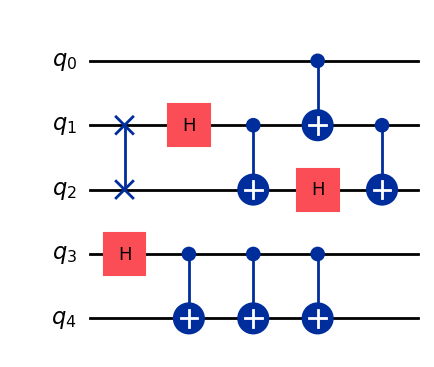

In [11]:
import qiskit.circuit.random
import qiskit
import qiskit.circuit.library.standard_gates
import random

import quariadne.circuit

QUBIT_COUNT = 5
NUM_GATES = 10
SEED = 156

random.seed(SEED)

MAX_OPERANDS = 2

STANDARD_GATE_SET = ["cx", "h", "swap"]



random_circuit = qiskit.QuantumCircuit(QUBIT_COUNT)
for operation_index in range(NUM_GATES):
    random_operation_label = random.choice(STANDARD_GATE_SET)
    if random_operation_label == "h":
        random_qubit = random.randint(0, QUBIT_COUNT-1)
        random_circuit.h(random_qubit)
    else:
        random_qubit_pair_first = random.randint(0, QUBIT_COUNT-2)
        random_qubit_pair_second = random_qubit_pair_first + 1

        if random_operation_label == "cx":
            random_circuit.cx(random_qubit_pair_first, random_qubit_pair_second)
        elif random_operation_label == "swap":
            random_circuit.swap(random_qubit_pair_first, random_qubit_pair_second)

random_circuit.draw('mpl')

Now let's generate random backend coupling map)

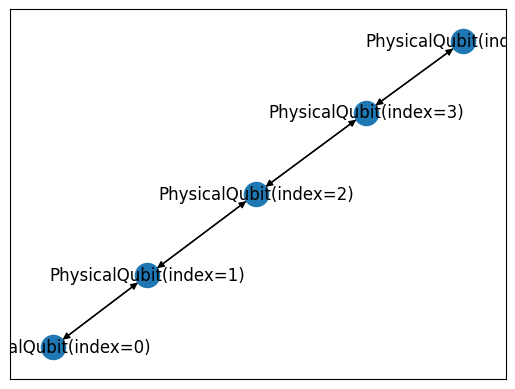

In [12]:
import qiskit_ibm_runtime.fake_provider 
import networkx as nx

manila_backend = qiskit_ibm_runtime.fake_provider.FakeManilaV2()
coupling_graph = manila_backend.coupling_map.graph
coupling_graph_nx = nx.DiGraph()

coupling_map_qubits = manila_backend.coupling_map.physical_qubits
physical_qubits = tuple(quariadne.circuit.PhysicalQubit(coupling_map_qubit) for coupling_map_qubit in coupling_map_qubits)
coupling_map_edgelist = manila_backend.coupling_map.graph.edge_list()
physical_qubits_connections = tuple((quariadne.circuit.PhysicalQubit(coupling_map_from), quariadne.circuit.PhysicalQubit(coupling_map_to)) for coupling_map_from, coupling_map_to in coupling_map_edgelist)
physical_qubits, physical_qubits_connections
coupling_graph_nx.add_nodes_from(physical_qubits)
coupling_graph_nx.add_edges_from(physical_qubits_connections)
nx.draw_networkx(coupling_graph_nx)

Finally, let's see an encapsulated version of the ciurcuti

In [13]:
random_abstract_circuit = quariadne.circuit.AbstractQuantumCircuit.from_qiskit_circuit(random_circuit)
random_abstract_circuit.operations

[QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=3),)),
 QuantumOperation(name='swap', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))),
 QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),)),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4))),
 QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=2),)),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)))]

Let's initialise the milp router, and run it then!

In [14]:
import quariadne.milp_router

lp_router = LpRouter(coupling_graph_nx, random_abstract_circuit)
lp_router_result = lp_router.run()
lp_router_result

logical_uniqueness_constraint (875, 36050) 1 1
physical_uniqueness_constraint (875, 36050) 1 1
gate_execution_constraint (7, 36050) 1 1
gate_mapping_constraint (56, 36050) 0 inf
gate_mapping_left_qubit_constraint (56, 36050) -inf 0
gate_mapping_right_qubit_constraint (56, 36050) -inf 0
gate_mapping_full_qubit_constraint (56, 36050) -1 inf
flow_condition_in_constraint (4350, 36050) 0 0
flow_condition_out_constraint (4375, 36050) 0 0


LpRouterResult(milp_result=        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.0
              x: [ 2.857e-01 -0.000e+00 ...  0.000e+00  1.429e-01]
 mip_node_count: None
 mip_dual_bound: None
        mip_gap: None, mapping_variables=array([[[ 0.28571429, -0.        , -0.        ,  0.57142857,
          0.14285714],
        [ 0.14285714,  0.28571429, -0.        , -0.        ,
          0.57142857],
        [ 0.42857143,  0.14285714,  0.28571429,  0.14285714,
         -0.        ],
        [ 0.14285714, -0.        ,  0.71428571, -0.        ,
          0.14285714],
        [-0.        ,  0.57142857, -0.        ,  0.28571429,
          0.14285714]],

       [[ 0.28571429, -0.        , -0.        ,  0.57142857,
          0.14285714],
        [ 0.14285714,  0.28571429, -0.        , -0.        ,
          0.57142857],
        [ 0.42857143,  0.14285714,  0.28571429,  0.14285714,
         -0.        ],
    